In [ ]:
#! pip install -r requirements.txt
#! pip install --force-reinstall -r requirements.txt

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from PIL import Image, ImageOps
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# from dataset import MyData
# from model import Net
from make_gif_from_folder import make_gif

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
print(device)

cuda:0


In [ ]:
class MyData(torch.utils.data.Dataset):
    def __init__(self, path_to_file, mode, reduce_fctor=1, need_help=False):
        self.need_help = need_help
        self.maps_markup = self.make_markup()
        self.reduce_factor = reduce_fctor
        self.img_array = self.get_img_array(path_to_file) if mode == 'img' else self.read_from_abz(path_to_file)
        # self.pm_array = self.get_pm_array(path_to_file)
        self.width, self.height = self.img_array.shape
        self.total_pixel = self.width * self.height
        self.bound_length = len(np.where(self.img_array < 255)[0])
        self.data_2d, self.data_3d = self.make_data()
        self.data_3d.x, self.data_3d.y, self.data_3d.z = self.data_3d[:, 0], self.data_3d[:, 1], self.data_3d[:, 2]
        print(f'width: {self.width}\n' +
              f'height: {self.height}\n' +
              f'total_pixel: {self.total_pixel}\n' +
              f'bound length: {self.bound_length}\n' +
              f'percent of bound pixels: {(100 * self.bound_length / self.total_pixel):.1f}%')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data_2d[idx], self.data_3d[idx]

    def get_img_array(self, path_to_file):
        return np.array(ImageOps.grayscale(Image.open(path_to_file))).astype(int)
    
    # def get_pm_array(self, path_to_file):
    #     filename='./data/pm_format/c1905.dat'
    #     with open(filename) as f:
    #         lines = [line[4:].replace('-1', '0').replace('+1', '1').rstrip() for line in f]
    #     pm_array = np.array([list(x) for x in lines], dtype = 'int')
    #     return pm_array
        
    def make_data(self):
        data_2d = torch.from_numpy(np.stack(np.indices((self.width, self.height)), axis=2).reshape(-1, 2)).float()
        data_2d[:, 0] -= data_2d[:, 0].mean()
        data_2d[:, 0] /= data_2d[:, 0].abs().max()
        data_2d[:, 1] -= data_2d[:, 1].mean()
        data_2d[:, 1] /= data_2d[:, 1].abs().max()
        data_3d = torch.stack((torch.cos(torch.pi * data_2d[:, 1]), torch.sin(torch.pi * data_2d[:, 1]), data_2d[:, 0]), dim=1)
        return data_2d, data_3d

    def make_markup(self):
        res = {}
        current = 0
        with open("./data/CL_23.txt", "r", encoding='windows-1251') as file:
            for line in file:
                try:
                    temp = list(map(int, line.rstrip().split()))
                except:
                    continue
                if len(temp) == 1:
                    current = temp[0]
                elif len(temp) == 0:
                    continue
                else:
                    if current not in res.keys():
                        res[current] = [temp[1:]] 
                    else:
                        res[current].append(temp[1:])
        return res

    def show_image(self):
        plt.figure(figsize=(10, 5))
        plt.title('Input Image')
        plt.imshow(self.img_array, cmap='gray', vmin=0, vmax=255)
    
    def read_from_abz(self, filename):
        with open(filename) as f:
            lines = [line.rstrip() for line in f]
        my_shape = [int(x) for x in lines[0].split()[-6:-4]]
        my_shape.reverse()
        img_array = np.full(shape=my_shape, fill_value=255)
        for line in lines[3:]:
            line = [int(x) for x in line.split()]
            if len(line) == 3:
                y = line[0]
                x1 = line[1]
                x2 = -line[2]
                for i in range(x1, x2 + 1):
                    img_array[min(y, my_shape[0] - 1), min(i, my_shape[1] - 1)] = 0
            elif len(line) == 5:
                y = line[0]
                x1 = line[1]
                x2 = -line[2]
                x3 = line[3]
                x4 = -line[4]
                for i in range(x1, x2 + 1):
                    img_array[min(y, my_shape[0] - 1), min(i, my_shape[1] - 1)] = 0
                for i in range(x3, x4 + 1):
                    img_array[min(y, my_shape[0] - 1), min(i, my_shape[1] - 1)] = 0
        if self.need_help:
            map_number = int(filename[-11:-7])
            i = 10
            for line in self.maps_markup[map_number]:    
                for el in line:
                    x, y = int(el * (my_shape[0] - 1) / 180.), int(i * (my_shape[1] - 1) / 360.)
                    img_array[x, y] = 0
                    img_array[min(x + 1, my_shape[0] - 1), y] = 0
                    img_array[max(x - 1, 0), y] = 0
                    img_array[x, min(y + 1, my_shape[1] - 1)] = 0
                    img_array[x, max(y - 1, 0)] = 0
                i += 10
        return img_array

    def show_3d(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.dataset.data_3d.x, self.dataset.data_3d.y, self.dataset.data_3d.z, c=self.dataset.img_array.flatten())

    def show_3d(self):
        df = pd.DataFrame({'x': self.data_3d.x[::self.reduce_factor], 
                            'y': self.data_3d.y[::self.reduce_factor], 
                            'z': -self.data_3d.z[::self.reduce_factor], 
                            'label': self.img_array.flatten()[::self.reduce_factor]})
        return px.scatter_3d(df, x='x', y='y', z='z', color='label').update_traces(marker={'size': 2})

In [ ]:
class Net(nn.Module):
    def __init__(self, dataset, lr, weight_decay=1e-3):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 6), nn.ELU(),
            nn.Linear(6, 12), nn.ELU(),
            nn.Linear(12, 24), nn.ELU(),
            # nn.Linear(16, 32), nn.ELU(),
            # nn.Linear(32, 64), nn.ELU(),
            # nn.Linear(64, 128), nn.ELU(),
            # nn.Linear(128, 64), nn.ELU(),
            # nn.Linear(64, 32), nn.ELU(),
            # # nn.Linear(32, 16), nn.ELU(),
            # nn.Linear(81, 27), nn.ELU(),
            # nn.Linear(27, 9), nn.ELU(),
            # nn.Linear(24, 8), nn.ELU(),
            nn.Linear(24, 1), nn.Tanh())
        # self.weight = torch.nn.Parameter(torch.FloatTensor([1]), requires_grad=True)
        self.dataset = dataset
        self.lr = lr
        self.weight_decay = weight_decay
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True, patience=100)        
        self.loss_dict = {'loss_trace': [],
                          'f_abs_integral_trace': [],
                          'bound_intgegral_trace': [],
                          'orientation_integral_trace': [],
                          'f_integral_trace': []}
        
    def forward(self, x):
        #x = x.cuda()
        output = self.net(x)
        return output
    
    def compute_and_plot_gradient(self, prediction):
        batch = self.dataset.data_3d
        batch.requires_grad_()
        tmp = self(batch.cuda())
        tmp.sum().backward()
        grad_out = batch.grad.cpu()
        plt.figure(figsize=(12, 6))
        plt.title(r'Gradient map for $||\nabla f(x,y,z)||_2$', fontsize=30)
        plt.imshow(((grad_out.pow(2).sum(dim=1)).pow(0.5)).view(self.dataset.img_array.shape), cmap='plasma')
        plt.colorbar()
        return grad_out

    def show_on_cylinder(self, prediction):
        df = pd.DataFrame({'x': self.dataset.data_3d.x.cpu().detach().numpy()[::self.dataset.reduce_factor],
                            'y': self.dataset.data_3d.y.cpu().detach().numpy()[::self.dataset.reduce_factor], 
                            'z': -self.dataset.data_3d.z.cpu().detach().numpy()[::self.dataset.reduce_factor], 
                            'label': prediction.flatten()[::self.dataset.reduce_factor]})
        return px.scatter_3d(df, x='x', y='y', z='z', color='label').update_traces(marker={'size': 2})

    def show_loss_items(self):
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 2, 1)
        plt.xlabel('Epoch')
        plt.ylabel('f_abs_integral_trace')
        plt.plot(self.loss_dict['f_abs_integral_trace'])

        plt.subplot(2, 2, 2)
        plt.xlabel('Epoch')
        plt.ylabel('bound_intgegral_trace')
        plt.plot(self.loss_dict['bound_intgegral_trace'])

        plt.subplot(2, 2, 3)
        plt.xlabel('Epoch')
        plt.ylabel('orientation_integral_trace')
        plt.plot(self.loss_dict['orientation_integral_trace'])

        plt.subplot(2, 2, 4)
        plt.xlabel('Epoch')
        plt.ylabel('f_integral_trace')
        plt.plot(self.loss_dict['f_integral_trace'])
        plt.show()
        
    def change_lr(self, lr):
        for g in self.optimizer.param_groups:
            g['lr'] = lr

    def restart_model(self, lr, weight_decay=1e-3):
        model = Net(dataset=self.dataset, lr=lr, weight_decay=weight_decay)
        model.to(device)
        return model

    def save_state_dict(self, path):
        torch.save(self.state_dict(), path)

    def test_model(self, input, need_plot=False):
        with torch.no_grad():
            output = self(input.cuda()).cpu().detach()
        if need_plot:
            plt.figure(figsize=(12, 6))
            plt.title('Visualization of the function $f(x,y,z)$')
            plt.imshow(output.view(self.dataset.img_array.shape), cmap='PuOr', vmin=-1, vmax=1) 
            plt.colorbar()
        return output


    def start_training(self, num_epochs, my_weight = 1e-1, show_frequency=1e+2):
        for _, value in self.loss_dict.items():
            value.clear()
        batch = self.dataset.data_3d.cuda()
        perm = torch.randperm(self.dataset.total_pixel)
        inv_perm = torch.argsort(perm)
        batch = batch[perm]
        dir_path = 'epoch_outs'
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        for epoch in range(1, int(num_epochs) + 1):
            output = self(batch)[inv_perm]
            self.optimizer.zero_grad()
            loss = self.compute_loss(output=output, epoch=epoch, my_weight=my_weight)
            loss.backward(retain_graph=True)
            self.optimizer.step()
            # scheduler.step(loss)
            if epoch % int(show_frequency) == 0:
                output = output.cpu().detach().numpy().reshape(self.dataset.img_array.shape)
                clear_output(wait=True)
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.plot(self.loss_dict['loss_trace'])
                plt.subplot(1, 2, 2)
                plt.imshow(output, cmap='PuOr', vmin=-1, vmax=1)
                plt.title(f'Epoch {epoch}')
                plt.colorbar()
                plt.savefig(dir_path + '/epoch%06d.png' % epoch)
                plt.show()

    def compute_loss(self, output, epoch, my_weight): # LENGTH BOUND
        mask = np.where(self.dataset.img_array.reshape(-1, 1) == 255)[0]
        bound_mask = np.where(self.dataset.img_array.reshape(-1, 1) < 255)[0]
        # bound_lenght_mask = np.where(output.abs < 0.5)
        f_integral = my_weight * output.sum().abs() / self.dataset.total_pixel
        row_numbers = 1
        upper_bound = (output[:row_numbers].sum() / len(output[:row_numbers]) - 1).abs()
        lower_bound = (output[-row_numbers:].sum() / len(output[-row_numbers:]) + 1).abs()
        orientation_integral = (upper_bound + lower_bound) / 4.
        f_abs_integral = 1 - output[mask].abs().sum() / (self.dataset.total_pixel - self.dataset.bound_length) # хочу НЕ границу +-1
        bound_intgegral = ((output[bound_mask].pow(2)).sum() / self.dataset.bound_length) # хочу на границе 0
        # bound_lenght = len(output[bound_lenght_mask])
        loss = f_abs_integral + bound_intgegral + orientation_integral + f_integral
        self.loss_dict['loss_trace'].append(loss.item())
        self.loss_dict['f_abs_integral_trace'].append(f_abs_integral.item())
        self.loss_dict['bound_intgegral_trace'].append(bound_intgegral.item())
        self.loss_dict['orientation_integral_trace'].append(orientation_integral.item())
        self.loss_dict['f_integral_trace'].append(f_integral.item())
        return loss
        # w_bound = torch.sigmoid(self.weight)
        # w_abs = 1 - w_bound
        # return (w_abs + 1) * f_abs_integral + (w_bound + 1) * bound_intgegral + orientation_integral, w_bound

In [ ]:
dataset=MyData(path_to_file='./imgs/1905_100_200_low.png', mode='img', reduce_fctor=1, need_help=False)
# dataset.show_3d()

width: 100
height: 200
total_pixel: 20000
bound length: 1110
percent of bound pixels: 5.5%


In [ ]:
model = Net(dataset=dataset, lr=1e-3)
model.to(device)
# summary(model, (1, 3))
model.load_state_dict(torch.load('./1905_low_low_1e-2_state_dict.pt'))

<All keys matched successfully>

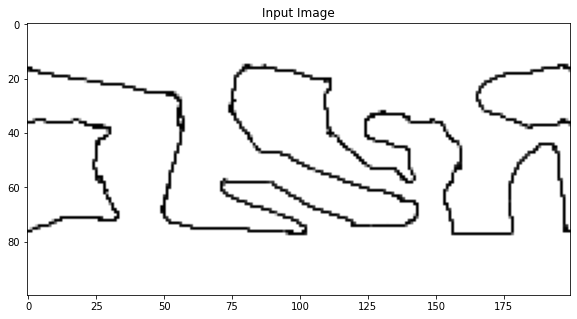

In [ ]:
dataset.show_image()

In [ ]:
# plt.imsave('out.png', dataset.img_array, cmap='gray')

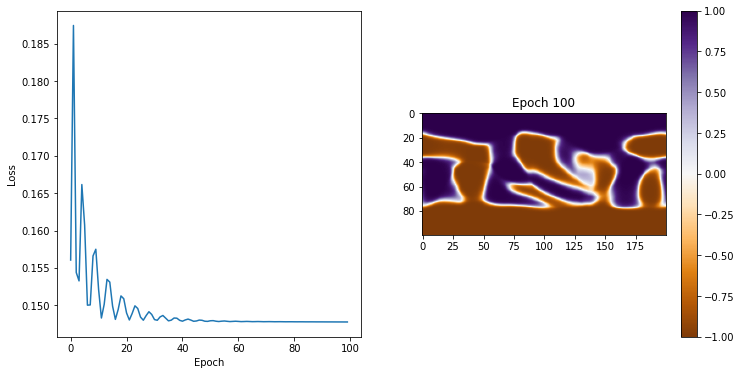

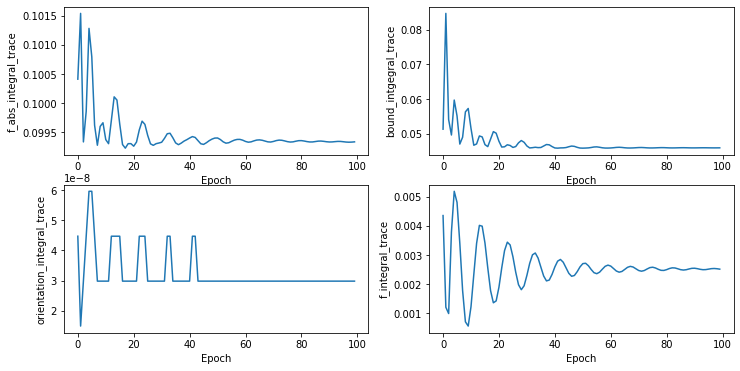

In [95]:
# model.change_lr(1e-4)
# model = model.restart_model(lr=1e-3)
model.start_training(num_epochs=1e+2, my_weight=0.1)
model.show_loss_items()

In [96]:
model.save_state_dict('./1905_low_low_1e-2_state_dict.pt')

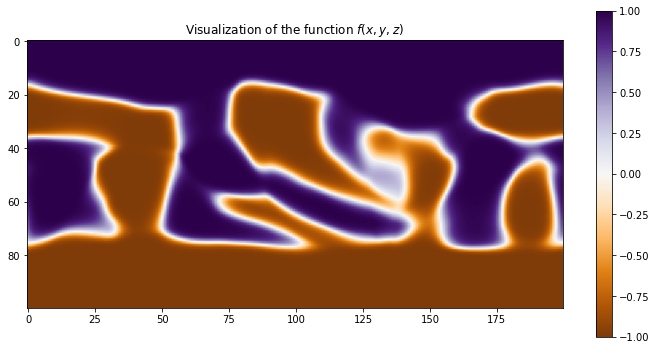

In [97]:
output = model.test_model(dataset.data_3d, need_plot=True)

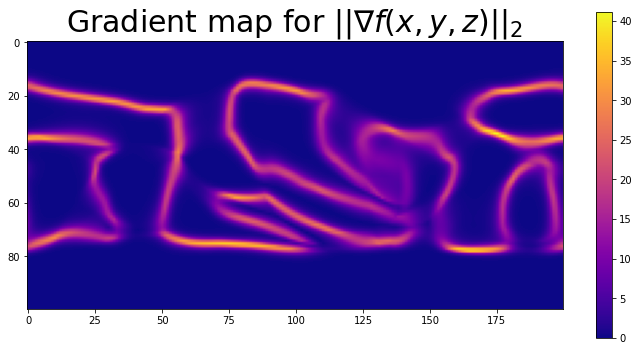

In [98]:
grad_out = model.compute_and_plot_gradient(output)

In [99]:
model.show_on_cylinder(prediction=output)

In [100]:
make_gif(dir_path='./epoch_outs', gifname='nice')

In [ ]:
plt.imsave('output.png', dataset.img_array, cmap='gray')

In [ ]:
data_2d = torch.from_numpy(np.stack(np.indices((dataset.width, dataset.height)), axis=2).reshape(-1, 2)).float()
data_2d[:, 0] -= data_2d[:, 0].mean()
data_2d[:, 0] /= data_2d[:, 0].abs().max()
data_2d[:, 1] -= data_2d[:, 1].mean()
data_2d[:, 1] /= data_2d[:, 1].abs().max()
data_3d = torch.stack((7 * torch.cos(torch.pi * data_2d[:, 1]), torch.sin(7 * torch.pi * data_2d[:, 1]), 1 * data_2d[:, 0]), dim=1)

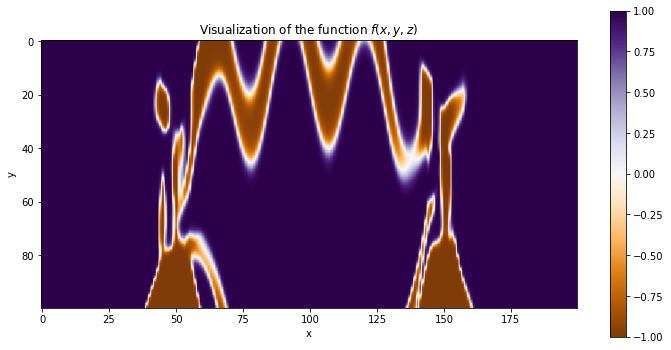

In [ ]:
input = data_3d
output = model.test_model(input, need_plot=True)

In [ ]:
a = dataset.data_3d